In [16]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)
import sys

sys.path.append('/home/azhuavlev/PycharmProjects/ml-neuman_mano/pytorch3d_nerf')
from mano_custom import mano_pytorch3d

device = torch.device("cuda:0")
import kaolin
import warping.kaolin_test as kaolin_test

kaolin_test.test_kaolin()
hand_model = mano_pytorch3d.create_mano_custom(return_right_hand=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
checking kaolin...
check_sign tensor([[ True, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False,  True, False, False,
         False, False, False,  True, False,  True, False]], device='cuda:0')
point_to_mesh_distance tensor([[ 0.2500, 41.0000]], device='cuda:0') tensor([[0, 0]], device='cuda:0') tensor([[5, 5]], device='cuda:0', dtype=torch.int32)
Fix shapedirs bug of MANO


In [17]:
import trimesh

faces_zero_pose = torch.from_numpy(hand_model.faces.astype(np.int32))[None, :, :]
verts_zero_pose = hand_model.get_flat_hand_vertices_pytorch3d('cpu')

mesh = trimesh.Trimesh(vertices=verts_zero_pose[0], faces=faces_zero_pose[0])
boundary_vertices = [92, 38, 122, 118, 117, 119, 120, 108, 79, 78, 121, 214, 215, 279, 239, 234][::-1]

centroid = mesh.vertices[boundary_vertices].mean(axis=0)
vertices_repaired = np.append(verts_zero_pose[0], centroid[None, :], axis=0)

new_faces = []
for i in range(len(boundary_vertices) - 1):
    next_i = i + 1 % len(boundary_vertices)
    new_faces.append([len(vertices_repaired) - 1, boundary_vertices[i], boundary_vertices[next_i]])
new_faces.append([len(vertices_repaired) - 1, boundary_vertices[len(boundary_vertices) - 1], boundary_vertices[0]])

faces_repaired = np.append(faces_zero_pose[0], new_faces, axis=0)

mesh_repaired_trimesh = trimesh.Trimesh(vertices=vertices_repaired, faces=faces_repaired)
print(mesh_repaired_trimesh.is_watertight)

True


In [18]:
# plot mesh_repaired with matplotlib as mesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(mesh_repaired_trimesh.vertices[:, 0], mesh_repaired_trimesh.vertices[:, 1],
                mesh_repaired_trimesh.vertices[:, 2], triangles=mesh_repaired_trimesh.faces)
ax.axis('equal')

<IPython.core.display.Javascript object>

(-0.08864399455487729,
 0.12368165366351605,
 -0.11006672810763121,
 0.10225892011076212)

In [42]:
import warping.get_point_mesh_face_distance as get_point_mesh_face_distance
import pytorch3d
import warping.get_closest_point_from_triangle as get_closest_point_from_triangle
import warping.get_closest_point_on_mesh_github as get_closest_point_on_mesh_github
import warping.get_vertex_uv as get_vertex_uv
import warping.barycentric_py3d as barycentric_py3d

from pytorch3d.io import load_obj
import pytorch3d
import igl


def test_pytorch3d_closest_pt(mesh, points):
    distances, face_ids = get_point_mesh_face_distance.point_mesh_face_distance(
        mesh,
        pytorch3d.structures.Pointclouds(points=points)
    )
    closest_pts = []
    distances_v2 = []
    for i in range(points.shape[1]):
        dist_v2, closest_point = get_closest_point_from_triangle.TestPointMeshDistance._point_to_tri_distance(
            points[0][i],
            mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]]
        )
        closest_pts.append(closest_point)
        distances_v2.append(dist_v2)
    closest_pts = torch.stack(closest_pts)
    distances_v2 = torch.stack(distances_v2)

    # get index where (distances-distances_v2).abs() is max
    # indx_max = (distances-distances_v2).abs().argmax()
    # print('max diff', (distances-distances_v2).abs().max())
    # print('max diff index', indx_max)
    # print('distances', distances[indx_max])
    # print('distances_v2', distances_v2[indx_max])

    return distances_v2, closest_pts


def test_github_closest_pt(mesh, points):
    distances, face_ids = get_point_mesh_face_distance.point_mesh_face_distance(
        mesh,
        pytorch3d.structures.Pointclouds(points=points)
    )
    clspt_gh = get_closest_point_on_mesh_github.ProjectMesh2Point(mesh)
    closest_points, dist_v3 = clspt_gh(
        points,
        face_ids.unsqueeze(0),
    )
    return closest_points


def test_pytorch3d_closest_pt_batched(mesh, points, vertices_repaired, faces_repaired):
    distances, face_ids = get_point_mesh_face_distance.point_mesh_face_distance(
        mesh,
        pytorch3d.structures.Pointclouds(points=points)
    )
    distances_v2, closest_points = get_closest_point_from_triangle.TestPointMeshDistance._point_to_tri_distance_batched(
        points[0],
        mesh.verts_packed()[mesh.faces_packed()[face_ids]]
    )
    closest_points_bary = get_closest_point_from_triangle.TestPointMeshDistance._point_to_bary_batched(
        closest_points,
        mesh.verts_packed()[mesh.faces_packed()[face_ids]]
    )

    distances_igl, closest_faces_igl, closest_pts_igl = igl.signed_distance(
    points.cpu().numpy()[0],
    verts_zero_pose.cpu().numpy()[0],
    faces_zero_pose.cpu().numpy()[0],
)

    print('difference closest_points and closest_pts_igl', (closest_points - torch.tensor(closest_pts_igl).to(device)).abs().sum())

    print(closest_points.detach().cpu().numpy().dtype)
    print(mesh.verts_packed()[mesh.faces_packed()[face_ids]].detach().cpu().numpy()[:, 0, :].dtype)
    closest_points_bary_igl = igl.barycentric_coordinates_tri(
        closest_points.detach().cpu().numpy().astype(np.float64),
        mesh.verts_packed()[mesh.faces_packed()[face_ids]].detach().cpu().numpy()[:, 0, :].astype(np.float64),
        mesh.verts_packed()[mesh.faces_packed()[face_ids]].detach().cpu().numpy()[:, 1, :].astype(np.float64),
        mesh.verts_packed()[mesh.faces_packed()[face_ids]].detach().cpu().numpy()[:, 2, :].astype(np.float64),
    )

    closest_points_bary_unbatched = []
    for i in range(closest_points.shape[0]):
        closest_points_bary_unbatched.append(
            get_closest_point_from_triangle.TestPointMeshDistance._point_to_bary(
                closest_points[i],
                mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]]
            )
        )
    closest_points_bary_unbatched = torch.stack(closest_points_bary_unbatched)

    closest_points_bary_trimesh = trimesh.triangles.points_to_barycentric(
        mesh.verts_packed()[mesh.faces_packed()[face_ids]].detach().cpu().numpy(),
        closest_points.detach().cpu().numpy(),
        method='cross'
    )

    # import pytorch3d

    closest_points_bary_another_py3d = []
    for i in range(closest_points.shape[0]):
        closest_points_bary_another_py3d.append(
            torch.tensor(
                barycentric_py3d.barycentric_coordinates(
                    closest_points[i],
                    mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]][0],
                    mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]][1],
                    mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]][2],
                ),
                device=closest_points.device
            )
        )
    closest_points_bary_another_py3d = torch.stack(closest_points_bary_another_py3d)

    # assert that each barycentric coordinate is between 0 and 1
    assert (closest_points_bary >= -1e-1).all() and (closest_points_bary <= 1 + 1e-1).all()
    closest_points_bary = closest_points_bary.clamp(0, 1)

    # print('closest_points_bary', closest_points_bary)
    # print('closest_points_bary_igl', closest_points_bary_igl)
    # print('closest_points_bary_trimesh', closest_points_bary_trimesh)

    distance_bary_py3d_igl = (closest_points_bary - torch.from_numpy(closest_points_bary_igl).to(
        closest_points_bary.device)).abs().sum(dim=-1)
    print('distance_bary_py3d_igl', distance_bary_py3d_igl.sum())
    distance_bary_batched_unbatched = (
                closest_points_bary - closest_points_bary_unbatched.to(closest_points_bary.device)).abs().sum(
        dim=-1).sum()
    # print('distance_bary_batched_unbatched', distance_bary_batched_unbatched)
    distance_bary_py3d_trimesh = (closest_points_bary - torch.from_numpy(closest_points_bary_trimesh).to(
        closest_points_bary.device)).abs().sum(dim=-1)
    print('distance_bary_py3d_trimesh', distance_bary_py3d_trimesh.sum())
    distance_bary_py3d_another_py3d = (
                closest_points_bary - closest_points_bary_another_py3d.to(closest_points_bary.device)).abs().sum(
        dim=-1).sum()
    # print('distance_bary_py3d_another_py3d', distance_bary_py3d_another_py3d.sum())
    distance_another_py3d_igl = (closest_points_bary_another_py3d - torch.from_numpy(closest_points_bary_igl).to(
        closest_points_bary.device)).abs().sum(dim=-1).sum()
    # print('distance_another_py3d_igl', distance_another_py3d_igl.sum())
    distance_unbatched_igl = (closest_points_bary_unbatched.to(closest_points_bary.device) - torch.from_numpy(
        closest_points_bary_igl).to(closest_points_bary.device)).abs().sum(dim=-1).sum()
    # print('distance_unbatched_igl', distance_unbatched_igl.sum())

    ind_wrong_bary = distance_bary_py3d_igl > 1e-2

    print('wrong bary igl', closest_points_bary_igl[ind_wrong_bary.cpu()])
    print('wrong bary py3d', closest_points_bary[ind_wrong_bary])

    print('points wrong bary', closest_points[ind_wrong_bary])
    print('vertices wrong bary', mesh.verts_packed()[mesh.faces_packed()[face_ids[ind_wrong_bary]]])

    uv_finder = get_vertex_uv.VertexUVFinder().to(closest_points_bary.device)

    closest_pts_uv = uv_finder.get_point_uv(closest_points_bary, face_ids)

    is_inside = kaolin.ops.mesh.check_sign(vertices_repaired, faces_repaired, points)
    print('is_inside', is_inside.int().sum())

    # multiply distances with -1 if point is inside
    distances_v2_signed = distances_v2.abs().sqrt() * (is_inside.int() * -2 + 1)

    print('n of pts inside, igl', (torch.from_numpy(distances_igl) < 0).int().sum())

    print('difference distances_v2 and distances', (distances_v2 - distances).abs().sum())

    print('difference distances_v2 and igl', (distances_v2_signed.cpu() - torch.from_numpy(distances_igl)).abs().sum())


    dist_to_closest_points = (closest_points - points).norm(dim=-1)
    dist_to_closest_points_signed = dist_to_closest_points * (is_inside.int() * -2 + 1)
    print('difference dist_to_closest_points_signed and igl', (dist_to_closest_points_signed.cpu() - torch.from_numpy(distances_igl)).abs().sum())

    dist_to_closest_points_igl = (torch.from_numpy(closest_pts_igl) - points.cpu()).norm(dim=-1)
    print('difference dist_to_closest_points_igl and igl', (dist_to_closest_points_igl[0].abs() - torch.from_numpy(distances_igl).abs()).abs().sum())

    print('difference distances_v2 and distances_to_closest_points', (distances_v2_signed.cpu() - dist_to_closest_points_signed.cpu()).abs().sum())


    wrong_distances = (dist_to_closest_points_igl - torch.from_numpy(distances_igl)).abs() > 1e-3
    print('wrong_distances', wrong_distances.sum())
    # print('wrong dist_to_closest_points_igl - distances_igl',
    #       dist_to_closest_points_igl[wrong_distances] - torch.from_numpy(distances_igl).unsqueeze(0)[wrong_distances])

    return distances_v2_signed, closest_points, closest_pts_uv, closest_points_bary


mesh_not_repaired = pytorch3d.structures.Meshes(
    verts=verts_zero_pose,
    faces=faces_zero_pose,
)

# points_to_query = pytorch3d.ops.sample_points_from_meshes(mesh_not_repaired, 1000000) * 2
points_to_query = torch.rand(1, 50000, 3) * 0.5 - 0.25

mesh_not_repaired = mesh_not_repaired.to(device)
points_to_query = points_to_query.to(device)

distances_batched, pts_batched, uvs_batched, closest_points_bary = test_pytorch3d_closest_pt_batched(
    mesh_not_repaired,
    points_to_query,
    torch.tensor(vertices_repaired).unsqueeze(0).to(device),
    torch.tensor(faces_repaired).to(device),
)

distances_unbatched, closest_pts_unbatched = test_pytorch3d_closest_pt(
    mesh_not_repaired,
    points_to_query,
)

# fixme: I am not entirely sure if everything is correct. Run experiments to check
# pts_batched

is_inside tensor(409, device='cuda:0')
n of pts inside, igl tensor(409)
difference closest_points - closest_pts_igl tensor(0.0509, device='cuda:0')
distance_bary_py3d - bary_igl tensor(0.0351, device='cuda:0', dtype=torch.float64)
difference distances_v2 - distance_kaolin tensor(1.8668e-05)
difference distances_v2 - distances_to_closest_points tensor(5.9108e-06)
difference dist_to_closest_points_igl and igl tensor(5.7333)
distances_igl - distance_kaolin tensor(5.7333)
difference distances_v2 - igl tensor(5.7347)


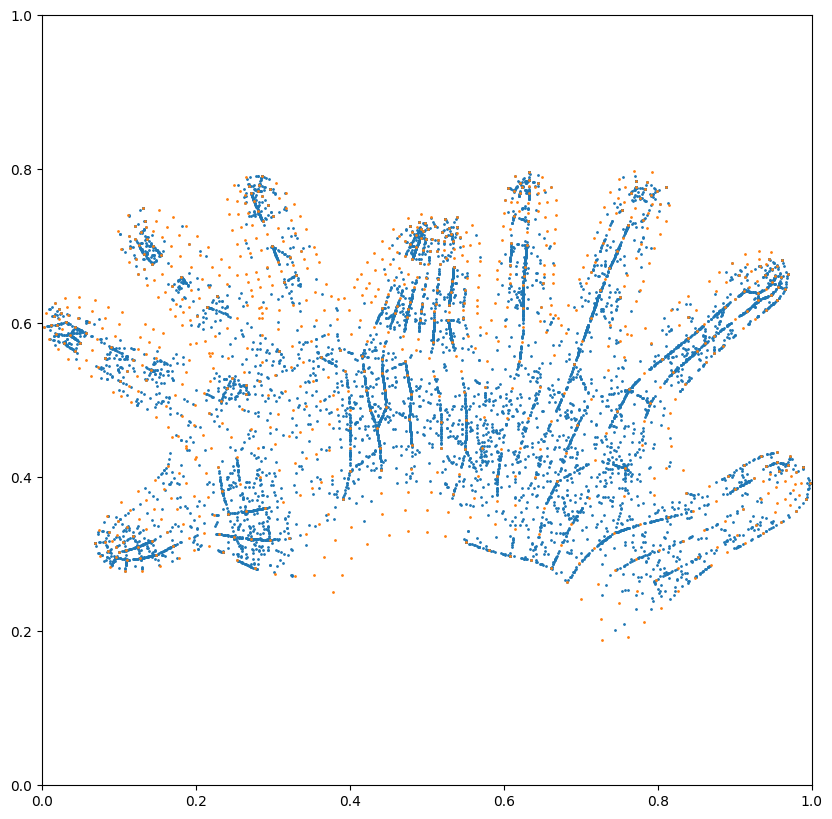

In [43]:
import igl

distances_igl, closest_faces_igl, closest_pts_igl = igl.signed_distance(
    points_to_query.cpu().numpy()[0],
    verts_zero_pose.cpu().numpy()[0],
    faces_zero_pose.cpu().numpy()[0],
)
print('pts_batched', pts_batched)
print('closest_pts_igl', closest_pts_igl)

# find squared distance between pts_batched and closest_pts_igl
distances_batched_igl = ((pts_batched - torch.tensor(closest_pts_igl).to(device)) ** 2).sum(dim=-1).sqrt()
distances_unbatched_igl = ((closest_pts_unbatched - torch.tensor(closest_pts_igl).to(device)) ** 2).sum(dim=-1).sqrt()

print('distances_batched_igl', distances_batched_igl.median() / distances_batched.median())
print('distances_unbatched_igl', distances_unbatched_igl.median() / distances_batched.median())
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(x=uvs_batched[:, 0].cpu().numpy(), y=uvs_batched[:, 1].cpu().numpy(), s=1)

# set axes equal
ax.set_aspect('equal', adjustable='box')
# set axes limits 0 to 1
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

print('batched pts', pts_batched)
print('batched distances', distances_batched.mean(), distances_batched.min(), distances_batched.max())
print('points_to_query', points_to_query)

verts_from_obj, faces_from_obj, aux = load_obj(
    '/itet-stor/azhuavlev/net_scratch/Projects/Data/models/mano/uv_maps/MANO_UV_left.obj')

print('aux.verts_uvs', aux.verts_uvs)

ax.scatter(x=aux.verts_uvs[:, 0].cpu().numpy(), y=aux.verts_uvs[:, 1].cpu().numpy(), s=1)

assert (faces_from_obj.verts_idx == faces_zero_pose).all()

# ax = fig.add_subplot(122, projection='3d')
#
# ax.plot_trisurf(mesh_repaired_trimesh.vertices[:, 0], mesh_repaired_trimesh.vertices[:, 1], mesh_repaired_trimesh.vertices[:, 2], triangles=mesh_repaired_trimesh.faces, alpha=0.5)
#
# ax.scatter(xs=points_to_query[0, :, 0].cpu().numpy(), ys=points_to_query[0, :, 1].cpu().numpy(), zs=points_to_query[0, :, 2].cpu().numpy(), s=1, c='r')
#
# ax.axis('equal')
# print('faces_from_obj', faces_from_obj.verts_idx)
# print('faces_zero_pose', faces_zero_pose)
print('pts_batched', pts_batched)
print('closest_pts_igl', closest_pts_igl)

In [ ]:
import kaolin
import warping.kaolin_test as kaolin_test

kaolin_test.test_kaolin()
pts_x = torch.linspace(-0.15, 0.15, 100)

points = torch.stack(torch.meshgrid(pts_x, pts_x, pts_x), dim=-1).reshape(1, -1, 3)
points.shape
import kaolin

is_inside = kaolin.ops.mesh.check_sign(vertices_repaired.to('cuda'), faces_repaired.to('cuda'), points.to('cuda'))
is_inside


In [ ]:
# plot 1000 random points on 3d plot, color red if inside, blue if outside
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
# select only points inside mesh
points_inside = points[is_inside.cpu().int() == 1].cpu()
indices = np.random.choice(points_inside.shape[0], 1000, replace=False)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_inside[indices, 0], points_inside[indices, 1], points_inside[indices, 2], c='r', marker='o')
ax.axis('equal')
is_inside.int().sum()
torch.cuda.is_available()
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# verts = torch.tensor([[[0., 0., 0.],
#                        [1., 0.5, 1.],
#                        [0.5, 1., 1.],
#                        [1., 1., 0.5]]], device=device)
# faces = torch.tensor([[0, 3, 1],
#                       [0, 1, 2],
#                       [0, 2, 3],
#                       [3, 2, 1]], device=device)
# axis = torch.linspace(0.1, 0.9, 3, device=device)
# p_x, p_y, p_z = torch.meshgrid(axis + 0.01, axis + 0.02, axis + 0.03)
# points = torch.cat((p_x.unsqueeze(-1), p_y.unsqueeze(-1), p_z.unsqueeze(-1)), dim=3)
# points = points.view(1, -1, 3)
# print('check_sign', kaolin.ops.mesh.check_sign(verts, faces, points))


In [ ]:
##############################################################################
# Test barycentric coordinates
##############################################################################

import warping.get_point_mesh_face_distance as get_point_mesh_face_distance
import pytorch3d
import warping.get_closest_point_from_triangle as get_closest_point_from_triangle
import warping.get_closest_point_on_mesh_github as get_closest_point_on_mesh_github
import warping.get_vertex_uv as get_vertex_uv
import warping.barycentric_py3d as barycentric_py3d

from pytorch3d.io import load_obj
import pytorch3d
import igl


def test_pytorch3d_closest_pt(mesh, points):
    distances, face_ids = get_point_mesh_face_distance.point_mesh_face_distance(
        mesh,
        pytorch3d.structures.Pointclouds(points=points)
    )
    closest_pts = []
    distances_v2 = []
    for i in range(points.shape[1]):
        dist_v2, closest_point = get_closest_point_from_triangle.TestPointMeshDistance._point_to_tri_distance(
            points[0][i],
            mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]]
        )
        closest_pts.append(closest_point)
        distances_v2.append(dist_v2)
    closest_pts = torch.stack(closest_pts)
    distances_v2 = torch.stack(distances_v2)

    # get index where (distances-distances_v2).abs() is max
    # indx_max = (distances-distances_v2).abs().argmax()
    # print('max diff', (distances-distances_v2).abs().max())
    # print('max diff index', indx_max)
    # print('distances', distances[indx_max])
    # print('distances_v2', distances_v2[indx_max])

    return distances_v2, closest_pts


def test_github_closest_pt(mesh, points):
    distances, face_ids = get_point_mesh_face_distance.point_mesh_face_distance(
        mesh,
        pytorch3d.structures.Pointclouds(points=points)
    )
    clspt_gh = get_closest_point_on_mesh_github.ProjectMesh2Point(mesh)
    closest_points, dist_v3 = clspt_gh(
        points,
        face_ids.unsqueeze(0),
    )
    return closest_points


def test_pytorch3d_closest_pt_batched(mesh, points, vertices_repaired, faces_repaired):
    distances, face_ids = get_point_mesh_face_distance.point_mesh_face_distance(
        mesh,
        pytorch3d.structures.Pointclouds(points=points)
    )
    distances_v2, closest_points = get_closest_point_from_triangle.TestPointMeshDistance._point_to_tri_distance_batched(
        points[0],
        mesh.verts_packed()[mesh.faces_packed()[face_ids]]
    )
    closest_points_bary = get_closest_point_from_triangle.TestPointMeshDistance._point_to_bary_batched(
        closest_points,
        mesh.verts_packed()[mesh.faces_packed()[face_ids]]
    )
    print(closest_points.detach().cpu().numpy().dtype)
    print(mesh.verts_packed()[mesh.faces_packed()[face_ids]].detach().cpu().numpy()[:, 0, :].dtype)
    closest_points_bary_igl = igl.barycentric_coordinates_tri(
        closest_points.detach().cpu().numpy().astype(np.float64),
        mesh.verts_packed()[mesh.faces_packed()[face_ids]].detach().cpu().numpy()[:, 0, :].astype(np.float64),
        mesh.verts_packed()[mesh.faces_packed()[face_ids]].detach().cpu().numpy()[:, 1, :].astype(np.float64),
        mesh.verts_packed()[mesh.faces_packed()[face_ids]].detach().cpu().numpy()[:, 2, :].astype(np.float64),
    )

    closest_points_bary_unbatched = []
    for i in range(closest_points.shape[0]):
        closest_points_bary_unbatched.append(
            get_closest_point_from_triangle.TestPointMeshDistance._point_to_bary(
                closest_points[i],
                mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]]
            )
        )
    closest_points_bary_unbatched = torch.stack(closest_points_bary_unbatched)

    closest_points_bary_trimesh = trimesh.triangles.points_to_barycentric(
        mesh.verts_packed()[mesh.faces_packed()[face_ids]].detach().cpu().numpy(),
        closest_points.detach().cpu().numpy(),
        method='cross'
    )

    # import pytorch3d

    closest_points_bary_another_py3d = []
    for i in range(closest_points.shape[0]):
        closest_points_bary_another_py3d.append(
            torch.tensor(
                barycentric_py3d.barycentric_coordinates(
                    closest_points[i],
                    mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]][0],
                    mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]][1],
                    mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]][2],
                ),
                device=closest_points.device
            )
        )
    closest_points_bary_another_py3d = torch.stack(closest_points_bary_another_py3d)

    # assert that each barycentric coordinate is between 0 and 1
    assert (closest_points_bary >= -1e-1).all() and (closest_points_bary <= 1 + 1e-1).all()
    closest_points_bary = closest_points_bary.clamp(0, 1)

    print('closest_points_bary', closest_points_bary)
    print('closest_points_bary_igl', closest_points_bary_igl)
    print('closest_points_bary_trimesh', closest_points_bary_trimesh)

    distance_bary_py3d_igl = (closest_points_bary - torch.from_numpy(closest_points_bary_igl).to(
        closest_points_bary.device)).abs().sum(dim=-1)
    print('distance_bary_py3d_igl', distance_bary_py3d_igl.sum())
    distance_bary_batched_unbatched = (
                closest_points_bary - closest_points_bary_unbatched.to(closest_points_bary.device)).abs().sum(
        dim=-1).sum()
    print('distance_bary_batched_unbatched', distance_bary_batched_unbatched)
    distance_bary_py3d_trimesh = (closest_points_bary - torch.from_numpy(closest_points_bary_trimesh).to(
        closest_points_bary.device)).abs().sum(dim=-1)
    print('distance_bary_py3d_trimesh', distance_bary_py3d_trimesh.sum())
    distance_bary_py3d_another_py3d = (
                closest_points_bary - closest_points_bary_another_py3d.to(closest_points_bary.device)).abs().sum(
        dim=-1).sum()
    print('distance_bary_py3d_another_py3d', distance_bary_py3d_another_py3d.sum())
    distance_another_py3d_igl = (closest_points_bary_another_py3d - torch.from_numpy(closest_points_bary_igl).to(
        closest_points_bary.device)).abs().sum(dim=-1).sum()
    print('distance_another_py3d_igl', distance_another_py3d_igl.sum())
    distance_unbatched_igl = (closest_points_bary_unbatched.to(closest_points_bary.device) - torch.from_numpy(
        closest_points_bary_igl).to(closest_points_bary.device)).abs().sum(dim=-1).sum()
    print('distance_unbatched_igl', distance_unbatched_igl.sum())

    ind_wrong_bary = distance_bary_py3d_igl > 1e-2

    print('wrong bary igl', closest_points_bary_igl[ind_wrong_bary.cpu()])
    print('wrong bary py3d', closest_points_bary[ind_wrong_bary])

    print('points wrong bary', closest_points[ind_wrong_bary])
    print('vertices wrong bary', mesh.verts_packed()[mesh.faces_packed()[face_ids[ind_wrong_bary]]])

    uv_finder = get_vertex_uv.VertexUVFinder().to(closest_points_bary.device)

    closest_pts_uv = uv_finder.get_point_uv(closest_points_bary, face_ids)

    is_inside = kaolin.ops.mesh.check_sign(vertices_repaired, faces_repaired, closest_points.unsqueeze(0))
    print('is_inside', is_inside.int().sum())
    # multiply distances with -1 if point is inside
    distances_v2 = distances_v2 * (is_inside.int() * -2 + 1)

    return distances_v2, closest_points, closest_pts_uv, closest_points_bary


mesh_not_repaired = pytorch3d.structures.Meshes(
    verts=verts_zero_pose,
    faces=faces_zero_pose,
)

# points_to_query = pytorch3d.ops.sample_points_from_meshes(mesh_not_repaired, 1000000) * 2
points_to_query = torch.rand(1, 5000, 3) * 0.5 - 0.25

mesh_not_repaired = mesh_not_repaired.to(device)
points_to_query = points_to_query.to(device)

distances_batched, pts_batched, uvs_batched, closest_points_bary = test_pytorch3d_closest_pt_batched(
    mesh_not_repaired,
    points_to_query,
    torch.tensor(vertices_repaired).unsqueeze(0).to(device),
    torch.tensor(faces_repaired).to(device),
)

distances_unbatched, closest_pts_unbatched = test_pytorch3d_closest_pt(
    mesh_not_repaired,
    points_to_query,
)

# fixme: I am not entirely sure if everything is correct. Run experiments to check
